In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import wfdb
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

In [2]:
data_path = 'mitdb/'

In [3]:
# Get the list of all record files in the folder
# List of Patients
data = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

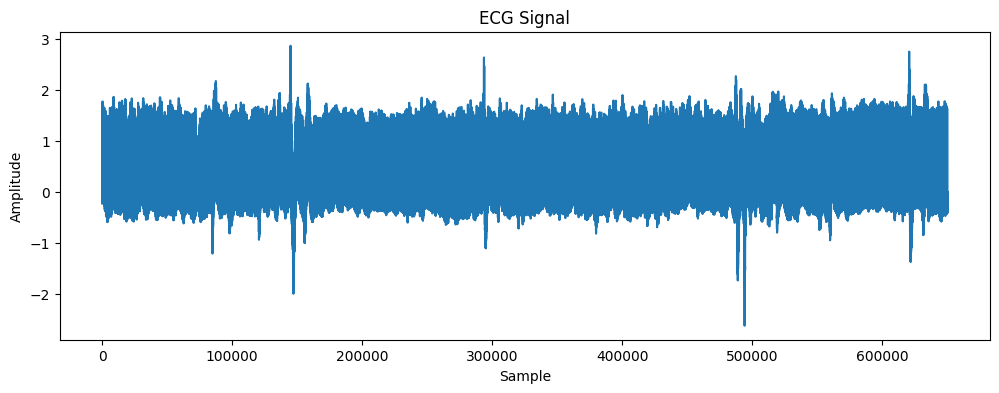

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in data:
    # Generating filepath for all .atr file names
    file = data_path + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'data Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

# Loop over all records and load the signal and annotations
for record_name in data:
    record_path = os.path.join(data_path, record_name)
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr', shift_samps=True)
    ecg_signal = record.p_signal[:,0]
    ecg_signal = np.nan_to_num(ecg_signal)

    # Get the signal and labels
    sig = ecg_signal
    labels = np.array(annotation.symbol)

plt.figure(figsize=(12, 4))
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal')
plt.show()

In [5]:
import numpy as np

# Menghitung kekuatan sinyal (Signal Power)
signal_power = np.var(sig)  # sig adalah sinyal asli

# Menghitung kekuatan noise (Noise Power)
# Untuk data EKG, noise seringkali dianggap sebagai seluruh sinyal karena noise dalam data EKG bervariasi
# Anda dapat menggunakan seluruh sinyal sebagai noise
noise_power = np.var(sig)

# Menghitung SNR
snr = 10 * np.log10(signal_power / noise_power)

print("SNR:", snr)


SNR: 0.0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import integrate, signal
from scipy.signal import resample, butter, filtfilt, find_peaks
import pywt
from scipy import integrate
import cv2

# Normalize the data
sig = (sig - np.mean(sig)) / np.std(sig)

# Resample the data to new_sampling_rate
new_sampling_rate = 250
record = {"fs": 1000}  # Define the sampling rate
sig_resampled = resample(sig, int(len(sig) * (new_sampling_rate / record["fs"])))

# Bandpass filter the data
lowcut = 5.0
highcut = 15.0
sampling_rate = new_sampling_rate

def bandpass_filter(data, lowcut, highcut, sampling_rate, order=4):
    nyq = 0.5 * sampling_rate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data


sig_filtered = bandpass_filter(sig_resampled, lowcut, highcut, sampling_rate, order=4)

def wavelet_denoising(data):
    waveletname = 'db6'
    threshold = 0.04
    level = pywt.dwt_max_level(len(data), waveletname)
    coeff = pywt.wavedec(data, waveletname, level=level)
    sigma = threshold*np.median(np.abs(coeff[-level]))
    uthresh = sigma*np.sqrt(2*np.log(len(data)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname)
    return reconstructed_signal

sig_denoised = wavelet_denoising(sig_filtered)

# Define structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate the signal
sig_dilated = cv2.dilate(sig_filtered, kernel)

# Erode the signal
sig_eroded = cv2.erode(sig_filtered, kernel)

# Perform opening operation on the signal
sig_opened = cv2.morphologyEx(sig_filtered, cv2.MORPH_OPEN, kernel)

# Extract morphological features
def extract_morphological_features(signal):
    features = {}
    
    # Calculate mean of the signal
    features['mean'] = np.mean(signal)
    
    # Calculate standard deviation of the signal
    features['std'] = np.std(signal)
    
    # Calculate maximum value of the signal
    features['max'] = np.max(signal)
    
    # Calculate minimum value of the signal
    features['min'] = np.min(signal)
    
    # Calculate median value of the signal
    features['median'] = np.median(signal)
    
    # Calculate skewness of the signal
    features['skew'] = scipy.stats.skew(signal)
    
    # Calculate kurtosis of the signal
    features['kurtosis'] = scipy.stats.kurtosis(signal)
    
    return features

# Calculate morphological features from the signals
morphological_features_filtered = extract_morphological_features(sig_filtered)
morphological_features_dilated = extract_morphological_features(sig_dilated)
morphological_features_eroded = extract_morphological_features(sig_eroded)
morphological_features_opened = extract_morphological_features(sig_opened)

In [7]:
sign = sig_filtered, sig_denoised, sig_dilated, sig_eroded, sig_opened

In [8]:
# Inisialisasi KFold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
sign_array = np.array(sign[3])
sign = np.squeeze(sign_array)  # Reshape the array to remove the singleton dimension

Train:  [     0      1      2 ... 162495 162498 162499] Test:  [     8     16     18 ... 162492 162496 162497]
Epoch 1/100
254/254 [==============================] - 5s 5ms/step - loss: 0.0796 - root_mean_squared_error: 0.2822 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 2/100
254/254 [==============================] - 1s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 1.9913e-04 - val_root_mean_squared_error: 0.0141
Epoch 3/100
254/254 [==============================] - 1s 4ms/step - loss: 1.0911e-04 - root_mean_squared_error: 0.0104 - val_loss: 7.2870e-05 - val_root_mean_squared_error: 0.0085
Epoch 4/100
254/254 [==============================] - 1s 3ms/step - loss: 4.3794e-05 - root_mean_squared_error: 0.0066 - val_loss: 2.1709e-05 - val_root_mean_squared_error: 0.0047
Epoch 5/100
254/254 [==============================] - 1s 3ms/step - loss: 1.6883e-05 - root_mean_squared_error: 0.0041 - val_loss: 5.9196e-06 - val_root_mean_squared_error: 0.0

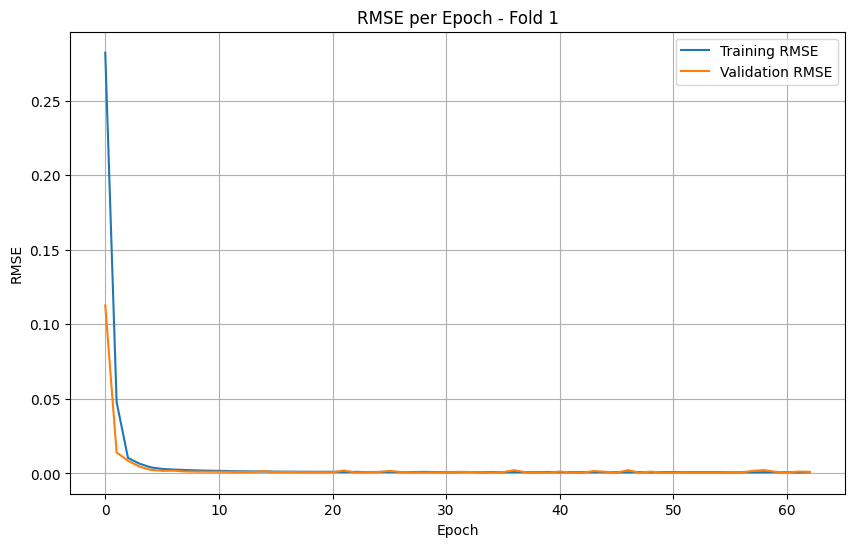

1016/1016 [==============================] - 3s 2ms/step
Signal to Noise Ratio (SNR) fold-1: 56.56829676122679
Root Mean Squared Error (RMSE) fold-1: 0.0005122737698726761
1016/1016 [==============================] - 2s 2ms/step
Train:  [     3      5      8 ... 162495 162496 162497] Test:  [     0      1      2 ... 162488 162498 162499]
Epoch 1/100
254/254 [==============================] - 9s 9ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 2/100
254/254 [==============================] - 2s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 1.4539e-04 - val_root_mean_squared_error: 0.0121
Epoch 3/100
254/254 [==============================] - 2s 6ms/step - loss: 1.0298e-04 - root_mean_squared_error: 0.0101 - val_loss: 4.6930e-05 - val_root_mean_squared_error: 0.0069
Epoch 4/100
254/254 [==============================] - 2s 6ms/step - loss: 4.7975e-05 - root_mean_squared_error: 0.0069 - val_los

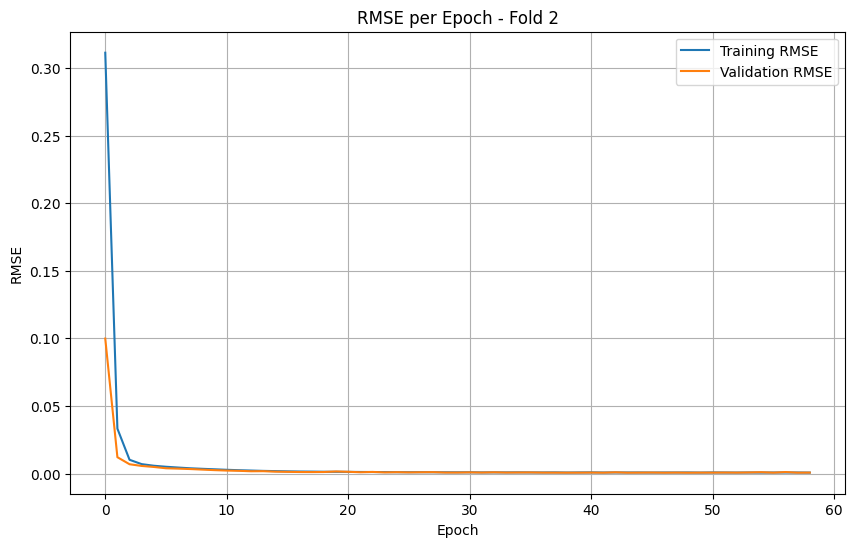

1016/1016 [==============================] - 2s 1ms/step
Signal to Noise Ratio (SNR) fold-2: 55.55206229778945
Root Mean Squared Error (RMSE) fold-2: 0.0005781541236311703
1016/1016 [==============================] - 1s 1ms/step
Train:  [     0      1      2 ... 162497 162498 162499] Test:  [     5     10     11 ... 162490 162491 162493]
Epoch 1/100
254/254 [==============================] - 5s 5ms/step - loss: 0.0778 - root_mean_squared_error: 0.2789 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 2/100
254/254 [==============================] - 1s 3ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 1.1132e-04 - val_root_mean_squared_error: 0.0106
Epoch 3/100
254/254 [==============================] - 1s 3ms/step - loss: 7.8883e-05 - root_mean_squared_error: 0.0089 - val_loss: 4.7982e-05 - val_root_mean_squared_error: 0.0069
Epoch 4/100
254/254 [==============================] - 1s 3ms/step - loss: 3.8680e-05 - root_mean_squared_error: 0.0062 - val_los

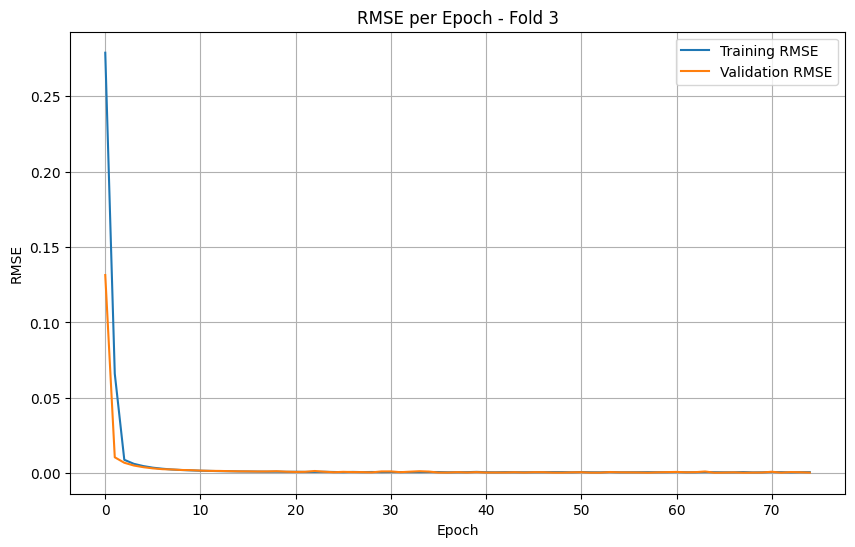

1016/1016 [==============================] - 3s 2ms/step
Signal to Noise Ratio (SNR) fold-3: 60.954240970503875
Root Mean Squared Error (RMSE) fold-3: 0.00030901331853932547
1016/1016 [==============================] - 2s 2ms/step
Train:  [     0      1      2 ... 162497 162498 162499] Test:  [     9     13     28 ... 162485 162486 162495]
Epoch 1/100
254/254 [==============================] - 8s 7ms/step - loss: 0.0727 - root_mean_squared_error: 0.2696 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 2/100
254/254 [==============================] - 1s 3ms/step - loss: 3.8186e-04 - root_mean_squared_error: 0.0195 - val_loss: 6.9070e-05 - val_root_mean_squared_error: 0.0083
Epoch 3/100
254/254 [==============================] - 1s 3ms/step - loss: 3.3418e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.4533e-05 - val_root_mean_squared_error: 0.0038
Epoch 4/100
254/254 [==============================] - 1s 3ms/step - loss: 1.0135e-05 - root_mean_squared_error: 0.0032 - v

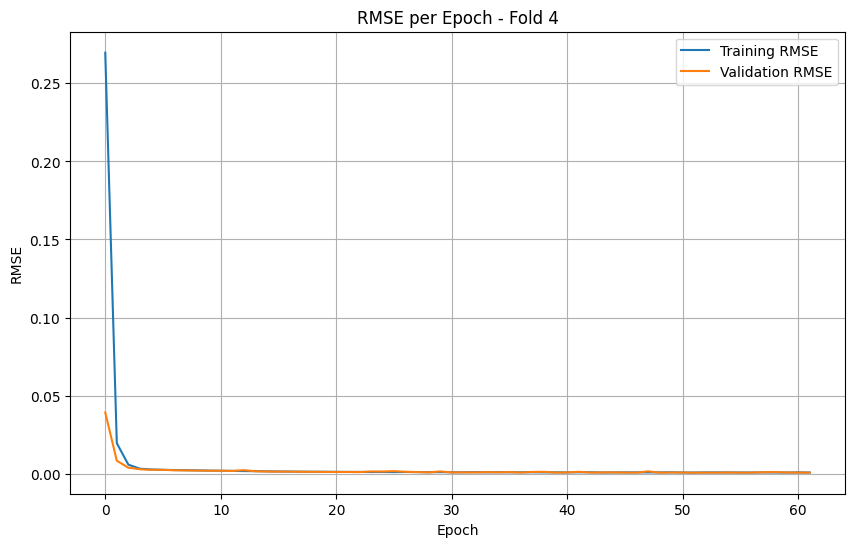

1016/1016 [==============================] - 3s 2ms/step
Signal to Noise Ratio (SNR) fold-4: 55.091942943096555
Root Mean Squared Error (RMSE) fold-4: 0.0006080270329787096
1016/1016 [==============================] - 2s 2ms/step
Train:  [     0      1      2 ... 162497 162498 162499] Test:  [     3     20     21 ... 162483 162487 162494]
Epoch 1/100
254/254 [==============================] - 8s 9ms/step - loss: 0.0705 - root_mean_squared_error: 0.2655 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2/100
254/254 [==============================] - 2s 6ms/step - loss: 2.3299e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.1721e-05 - val_root_mean_squared_error: 0.0065
Epoch 3/100
254/254 [==============================] - 2s 6ms/step - loss: 2.4458e-05 - root_mean_squared_error: 0.0049 - val_loss: 2.8800e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/100
254/254 [==============================] - 2s 6ms/step - loss: 1.6306e-05 - root_mean_squared_error: 0.0040 - va

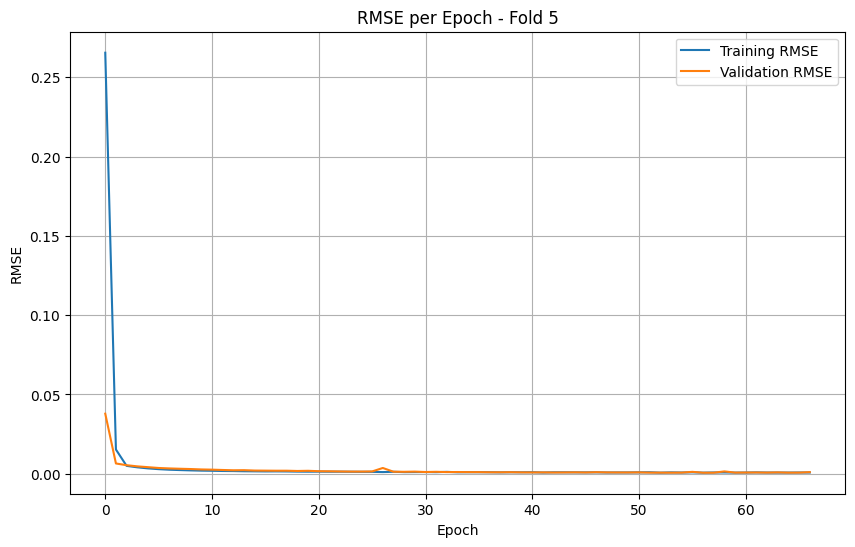

1016/1016 [==============================] - 3s 2ms/step
Signal to Noise Ratio (SNR) fold-5: 54.85601578814845
Root Mean Squared Error (RMSE) fold-5: 0.0006254675319624461
1016/1016 [==============================] - 2s 2ms/step


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

# Inisialisasi KFold
kfold = KFold(n_splits=5, shuffle=True)

result_snr = []
result_rmse = []
result_val_snr = []  # Menyimpan SNR validasi untuk setiap fold
result_val_rmse = []  # Menyimpan RMSE validasi untuk setiap fold
list_denoised_data = []
i = 1

# Menginisialisasi hyperparameters
window_size = 1
epochs = 100
batch_size = 128

for train_index, test_index in kfold.split(sign):
    # Print index data train dan test
    print("Train: ", train_index, "Test: ", test_index)

    # Mendapatkan data train dan test
    train_data, test_data = sign[train_index], sign[test_index]

    # Reshape data train dan test
    train_data = np.reshape(train_data, (train_data.shape[0], window_size, 1))
    test_data = np.reshape(test_data, (test_data.shape[0], window_size, 1))

    # Membangun model
    model = Sequential()

    # Encoder
    model.add(LSTM(16, activation='relu', input_shape=(window_size, 1), return_sequences=True))
    model.add(LSTM(8, activation='relu', return_sequences=False))

    # Decoder
    model.add(RepeatVector(window_size))
    model.add(LSTM(8, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer='adam', loss='mse')
    
    # Menambahkan Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Menambahkan loss function dan metrics ke model
    model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

    # Melatih model
    history = model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(test_data, test_data), callbacks=[early_stopping])

    # Plot RMSE tiap epoch
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title(f'RMSE per Epoch - Fold {i}')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Menggunakan model untuk denoising data
    denoised_data = model.predict(test_data)

    # Menghitung sinyal asli
    asli = np.max(test_data, axis=1)

    # Menghitung sinyal noise
    noise = asli - np.max(denoised_data, axis=1)

    # Menghitung SNR
    snr = 10 * np.log10(np.sum(asli ** 2) / np.sum(noise ** 2))

    # Menghitung RMSE
    rmse = np.sqrt(mean_squared_error(asli, np.max(denoised_data, axis=1)))

    # Menampilkan hasil SNR dan RMSE
    print(f'Signal to Noise Ratio (SNR) fold-{i}:', snr)
    print(f'Root Mean Squared Error (RMSE) fold-{i}:', rmse)

    result_snr.append(snr)
    result_rmse.append(rmse)
    
    # Menghitung SNR dan RMSE validasi
    val_denoised_data = model.predict(test_data)
    val_asli = np.max(test_data, axis=1)
    val_noise = val_asli - np.max(val_denoised_data, axis=1)
    val_snr = 10 * np.log10(np.sum(val_asli ** 2) / np.sum(val_noise ** 2))
    val_rmse = np.sqrt(mean_squared_error(val_asli, np.max(val_denoised_data, axis=1)))
    
    result_val_snr.append(val_snr)
    result_val_rmse.append(val_rmse)
    
    list_denoised_data.append(denoised_data)
    i += 1

In [11]:
# Menambahkan rata-rata dari hasil SNR
average_snr = np.mean(result_snr)

# Mencetak hasil SNR dan rata-rata
k = 1
for snr_value in result_snr:
    print(f"Hasil SNR ke-{k}: {snr_value}")
    k += 1

# Mencetak rata-rata SNR
print(f"Rata-rata SNR: {average_snr}")


Hasil SNR ke-1: 56.56829676122679
Hasil SNR ke-2: 55.55206229778945
Hasil SNR ke-3: 60.954240970503875
Hasil SNR ke-4: 55.091942943096555
Hasil SNR ke-5: 54.85601578814845
Rata-rata SNR: 56.60451175215303


In [12]:
# Menambahkan rata-rata dari hasil RMSE
average_rmse = np.mean(result_rmse)

# Mencetak hasil RMSE dan rata-rata
k = 1
for rmse_value in result_rmse:
    print(f"Hasil RMSE ke-{k}: {rmse_value}")
    k += 1

# Mencetak rata-rata RMSE
print(f"Rata-rata RMSE: {average_rmse}")


Hasil RMSE ke-1: 0.0005122737698726761
Hasil RMSE ke-2: 0.0005781541236311703
Hasil RMSE ke-3: 0.00030901331853932547
Hasil RMSE ke-4: 0.0006080270329787096
Hasil RMSE ke-5: 0.0006254675319624461
Rata-rata RMSE: 0.0005265871553968655
